### Load images
- how to do this in on-the-fly way?

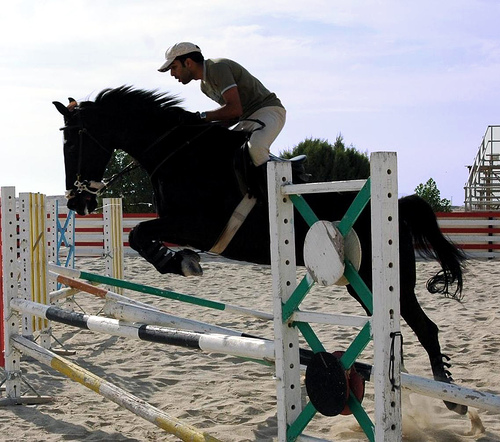

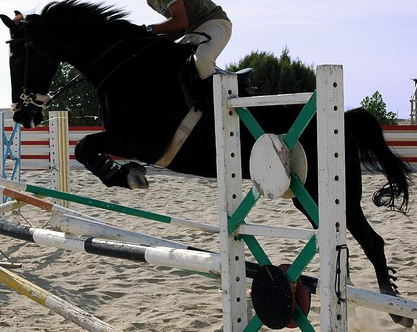

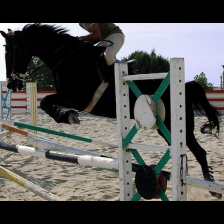

[string "require 'image'..."]:51: attempt to call method 'type' (a nil value)
stack traceback:
	[string "require 'image'..."]:51: in main chunk
	[C]: in function 'xpcall'
	/home/nine/.torch/install/share/lua/5.1/itorch/main.lua:179: in function </home/nine/.torch/install/share/lua/5.1/itorch/main.lua:143>
	/home/nine/.torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/nine/.torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/nine/.torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/nine/.torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/nine/.torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

horse	


In [58]:
require 'image'
require 'pl'
stringx.import()

image_dir = 'dataset/attribute/apascal_images/'

function load_data(filename)    
    local data = {}
    local txt = io.open(filename)
    for line in txt:lines() do
        line = line:split(' ')
        
        local instance = {}
        instance.fileloc = image_dir..line[1]
        instance.class = line[2]
        instance.crop = {lu = {x = tonumber(line[3]), y = tonumber(line[4]) },
                         rl = {x = tonumber(line[5]), y = tonumber(line[6]) } }
        instance.attribute = {}
        for i=7,70 do
            instance.attribute[i-6] = tonumber(line[i])
        end
        instance.image = image.load(instance.fileloc)
        instance.cropped_image = image.crop(instance.image, instance.crop.lu.x, instance.crop.lu.y, instance.crop.rl.x, instance.crop.rl.y )
        
        resized = image.scale(instance.cropped_image,224)
        instance.resized = torch.Tensor(3,224,224):zero()
        
        top_margin = ( 224 - resized:size(2) ) / 2 + 1
        left_margin = ( 224 - resized:size(3) ) / 2 + 1
        sub = instance.resized:sub(1, 3, top_margin, top_margin+resized:size(2)-1 , left_margin, left_margin+resized:size(3)-1):copy(resized)

        data[#data+1] = instance
        
        --[ For test ]--
        if( #data > 100 ) then
            break
        end
    end
    txt:close()
    return data
end

train_data = load_data('dataset/attribute/attribute_data/apascal_train.txt')
test_data  = load_data('dataset/attribute/attribute_data/apascal_test.txt')

itorch.image(train_data[1].image)
itorch.image(train_data[1].cropped_image)
itorch.image(train_data[1].resized)
print (train_data[1].class)


-- print (train_data)


In [2]:
require 'residual-layers'
require 'nn'
require 'cutorch'
require 'cunn'
require 'cudnn'
require 'nngraph'
require 'train-helpers'

torch.setdefaulttensortype('torch.FloatTensor')
cutorch.setDevice(3)
--[[
opt = lapp[[
      --batchSize       (default 128)      Sub-batch size
      --iterSize        (default 1)       How many sub-batches in each batch
      --Nsize           (default 3)       Model has 6*n+2 layers.
      --dataRoot        (default ./dataset/cifar-10-batches-t7) Data root folder
      --loadFrom        (default "")      Model to load
      --experimentName  (default "snapshots/cifar-residual-experiment1")
    ]]
--[[
print(opt)
--]]

In [3]:
--------------------------------------------------------Building Model
input = nn.Identity()()
------> 64, 224,224
model = cudnn.SpatialConvolution(3, 64, 7,7, 2,2, 3,3)(input)
------> 64, 112,112
--model = nn.SpatialBatchNormalization(64)(model)
model = cudnn.ReLU(true)(model)
model = cudnn.SpatialMaxPooling(3,3,  2,2,  1,1)(model)
------> 64, 56,56
model = addResidualLayer2(model, 64)
model = addResidualLayer2(model, 64)
model = addResidualLayer2(model, 64)
------> 64, 56,56
model = cudnn.SpatialAveragePooling(56, 56, 1,1, 0,0)(model)
------> 64, 1, 1
model = nn.Reshape(64)(model)
------> 64
model = nn.Linear(64,64)(model)
model = nn.BatchNormalization(64)(model)
model = nn.Sigmoid()(model)
model = nn.SplitTable(2,64)(model)
--------------------------------------------------------Building Model End
--------------------------------------------------------Parameter initialize 
model = nn.gModule({input}, {model})
model:cuda()
model:apply(function(m)
    -- Initialize weights
    local name = torch.type(m)
    if name:find('Convolution') then
        m.weight:normal(0.0, math.sqrt(2/(m.nInputPlane*m.kW*m.kH)))
        m.bias:fill(0)
    elseif name:find('BatchNormalization') then
        if m.weight then m.weight:normal(1.0, 0.002) end
        if m.bias then m.bias:fill(0) end
    end
end)
--------------------------------------------------------Parameter initialize End
--------------------------------------------------------Loss
loss = nn.ParallelCriterion()
for i = 1,64 do
    local bce = nn.BCECriterion():cuda()
    loss:add( bce )
end
loss:cuda()
--------------------------------------------------------Loss End
-- graph.dot(model.fg, 'mymodel', 'mymodel')

In [16]:
sgdState = {
   --- For SGD with momentum ---
   --[[
   learningRate   = "will be set later",
   weightDecay    = 1e-4,
   -- Settings from their paper
   --learningRate = 0.1,
   --weightDecay    = 1e-4,

   momentum     = 0.9,
   dampening    = 0,
   nesterov     = true,
   --]]
   --- For rmsprop, which is very fiddly and I don't trust it at all ---
   ----[[
   learningRate = 1e-5,
   alpha = 0.9,
   whichOptimMethod = 'rmsprop',
   --]]
   --- For adadelta, which sucks ---
   --[[
   rho              = 0.3,
   whichOptimMethod = 'adadelta',
   --]]
   --- For adagrad, which also sucks ---
   --[[
   learningRate = 3e-4,
   whichOptimMethod = 'adagrad',
   --]]
   --- For adam, which also sucks ---
   --[[
   learningRate = 0.005,
   whichOptimMethod = 'adam',
   --]]
   --- For the alternate implementation of NAG ---
   --[[
   learningRate = 0.01,
   weightDecay = 1e-6,
   momentum = 0.9,
   whichOptimMethod = 'nag',
   --]]
}

weights, gradients = model:getParameters()

function forwardBackward()
    model:training()
    gradients:zero()

    local inputs = torch.Tensor(2,3,224,224)
    inputs:select(1,1):copy(train_data[1].resized)
    inputs:select(1,2):copy(train_data[2].resized)
    inputs = inputs:cuda()

    local labels = {}
    for i = 1,64 do
        local label = torch.Tensor(2)
        label[1] = (train_data[1].attribute[i])
        label[2] = (train_data[2].attribute[i])
        labels[i] = label:cuda()
    end

    collectgarbage(); collectgarbage();
    local y = model:forward(inputs)

    -- for i = 1,64 do
    --     y[i] = y[i]:float()
    -- end

    -- print (y)
    -- print (labels)

    local loss_val = loss:forward(y, labels)
    local df_dw = loss:backward(y, labels)
    
    model:backward(inputs, df_dw)
    
end
-- for i = 1,64 do
--     print (loss.criterions[i].output)
-- end
print( loss_val ) 
--print (df_dw)


optimizer = optim['rmsprop']
optimizer(function() return loss_val, gradients end, weights, sgdState)


-- loss_val = loss_val / N
-- gradients:mul( 1.0 / N )


51.255522504449	


In [78]:
local batch = torch.Tensor(2,3,224,224):float()
batch:select(1,1):copy(train_data[1].resized)
batch:select(1,2):copy(train_data[2].resized)
local labels = {}
for i = 1,64 do
    local label = torch.Tensor(2):float()
    label[1] = (train_data[1].attribute[i])
    label[2] = (train_data[2].attribute[i])
    labels[i] = label
end
--print (batch)
--print (labels)
collectgarbage(); collectgarbage();
local y = model:forward(batch:cuda())
--print(y)
print (y[2])


 0.7316
 0.2684
[torch.CudaTensor of size 2]



In [111]:
for i,module in ipairs(loss:listModules()) do
   print(module)
end

[string "for i,module in ipairs(loss:listModules()) do..."]:1: attempt to call method 'listModules' (a nil value)
stack traceback:
	[string "for i,module in ipairs(loss:listModules()) do..."]:1: in main chunk
	[C]: in function 'xpcall'
	/home/nine/.torch/install/share/lua/5.1/itorch/main.lua:179: in function </home/nine/.torch/install/share/lua/5.1/itorch/main.lua:143>
	/home/nine/.torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/nine/.torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/nine/.torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/nine/.torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/nine/.torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

In [15]:
package.loaded['apascal-dataset'] = nil
Dataset = nil
-- remove the global registration:
debug.getregistry()['Dataset'] = nil    

require 'apascal-dataset'

In [20]:
dataset = Dataset('dataset/attribute/attribute_data/',
                  'dataset/attribute/apascal_images/',
                   torch.Tensor({0.0,0,0,0,0}),1.0
                   ,10)
print (dataset:size())

6340	6355	


In [11]:
co = coroutine.create( function()
    for i=1,10 do
        coroutine.yield(i)
    end
end)

while true do
    flag, x = coroutine.resume(co)
    if (x == nil) then 
        break 
    end
end

true	1	


true	

2	


true	

3	


true	4	


true	5	
true	

6	


true	7	


true	8	


true	9	
true	10	
